# XAI for Digit Classification (MNIST) — SHAP & LIME Explanations

**Goal:** Use Explainable AI tools (SHAP preferred, LIME fallback) to interpret a digit classification model (MNIST / handwritten digits).  
This notebook will:

1. Load or train a CNN digit classifier.
2. Evaluate model performance.
3. Generate a global explanation (feature importance / average influence across images) if possible.
4. Select two instances:
   - Case A: Correct prediction with high confidence.
   - Case B: Misclassified instance (false positive / false negative).
5. Produce local explanations for both instances and analyze why the model succeeded / failed.

**Notes:**  
- For image models, SHAP's `DeepExplainer` or `GradientExplainer` is used.  
- SHAP image plots require `shap` and `tensorflow` / `keras`. If SHAP is not installed or can't run in your environment, the notebook will attempt to use **LIME** for image explanations.

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from pathlib import Path

np.random.seed(42)
random.seed(42)

MODEL_FILENAME = "digit_model.h5"

## Load MNIST Dataset
We will use `keras.datasets.mnist` for training / testing the digit classifier.

In [12]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)

print("Train shape:", x_train.shape, "Test shape:", x_test.shape)

Train shape: (60000, 28, 28, 1) Test shape: (10000, 28, 28, 1)


## Load or Train a Small CNN Model
If `digit_model.h5` is present it will be loaded; otherwise a small CNN will be trained and saved.

In [13]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_cnn(input_shape=(28,28,1), num_classes=10):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

if os.path.exists(MODEL_FILENAME):
    print(f"Loading model from {MODEL_FILENAME}...")
    model = load_model(MODEL_FILENAME)
else:
    print("No saved model found — training a new CNN (this may take a few minutes)...")
    model = build_cnn()

    es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
    mc = ModelCheckpoint(MODEL_FILENAME, monitor='val_accuracy', save_best_only=True, verbose=1)

    model.fit(x_train, y_train_cat, validation_split=0.1, epochs=10, batch_size=128, callbacks=[es, mc])
    print(f"Model trained and saved to {MODEL_FILENAME}")


Loading model from digit_model.h5...


## Evaluate Model
Print overall accuracy and show a confusion subset if needed.

In [14]:
loss, acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test loss: {loss:.4f} | Test accuracy: {acc:.4f}")

Test loss: 0.0249 | Test accuracy: 0.9921


## Get predictions and probabilities
We will need predicted labels and per-class probabilities to pick Case A and Case B.

In [15]:
pred_probs = model.predict(x_test)
pred_labels = np.argmax(pred_probs, axis=1)
correct_mask = (pred_labels == y_test)
incorrect_mask = ~correct_mask

n_correct = correct_mask.sum()
n_incorrect = incorrect_mask.sum()
print(f"Correct: {n_correct}, Incorrect: {n_incorrect}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Correct: 9921, Incorrect: 79


## Choose Case A (correct & high confidence) and Case B (misclassified)
- Case A: choose a correctly predicted sample with highest softmax probability for its predicted class.
- Case B: choose a misclassified sample (first found) or choose the misclassified sample with highest predicted probability (wrong but confident).

In [16]:
correct_indices = np.where(correct_mask)[0]
correct_confidences = pred_probs[correct_indices, pred_labels[correct_indices]]
caseA_idx = correct_indices[np.argmax(correct_confidences)]

incorrect_indices = np.where(incorrect_mask)[0]
incorrect_confidences = pred_probs[incorrect_indices, pred_labels[incorrect_indices]]
caseB_idx = incorrect_indices[np.argmax(incorrect_confidences)]

print("Case A index (correct & high conf):", caseA_idx, "True label:", y_test[caseA_idx], "Pred:", pred_labels[caseA_idx], "Conf:", pred_probs[caseA_idx].max())
print("Case B index (misclassified & high conf):", caseB_idx, "True label:", y_test[caseB_idx], "Pred:", pred_labels[caseB_idx], "Conf:", pred_probs[caseB_idx].max())

Case A index (correct & high conf): 10 True label: 0 Pred: 0 Conf: 1.0
Case B index (misclassified & high conf): 3520 True label: 6 Pred: 4 Conf: 0.9996488


## Visualize the two selected images and model outputs

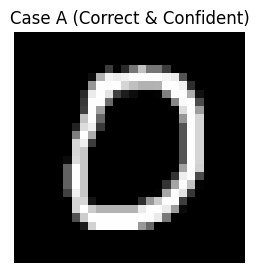

Top-3 predicted probs (class:prob): [(0, 1.0), (2, 8.413215901725835e-09), (8, 2.2260044918454014e-09)]


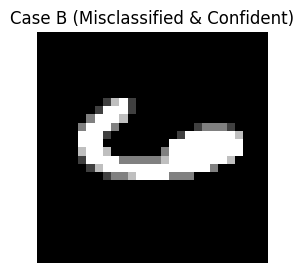

Top-3 predicted probs (class:prob): [(4, 0.9996488094329834), (9, 0.00018977381114382297), (8, 0.0001426569651812315)]


In [17]:
def plot_digit_with_probs(idx, title=None):
    img = x_test[idx].squeeze()
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    pred = pred_labels[idx]
    true = y_test[idx]
    conf = pred_probs[idx][pred]
    if title is None:
        title = f"Index {idx} | True: {true} | Pred: {pred} (conf={conf:.2f})"
    plt.title(title)
    plt.show()

    top3 = np.argsort(pred_probs[idx])[-3:][::-1]
    print("Top-3 predicted probs (class:prob):", [(int(c), float(pred_probs[idx][c])) for c in top3])

plot_digit_with_probs(caseA_idx, title="Case A (Correct & Confident)")
plot_digit_with_probs(caseB_idx, title="Case B (Misclassified & Confident)")

## SHAP Explanations (DeepExplainer / GradientExplainer)
We will attempt to use SHAP for image explanations. SHAP requires background samples; we'll use a small background set sampled from the training set.
If SHAP is unavailable or fails, a LIME fallback is provided later.

c:\Users\dalro\eclipse-workspace\Student\src\students\tf_env\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(10, 28, 28, 1))']
  warnings.warn(msg)


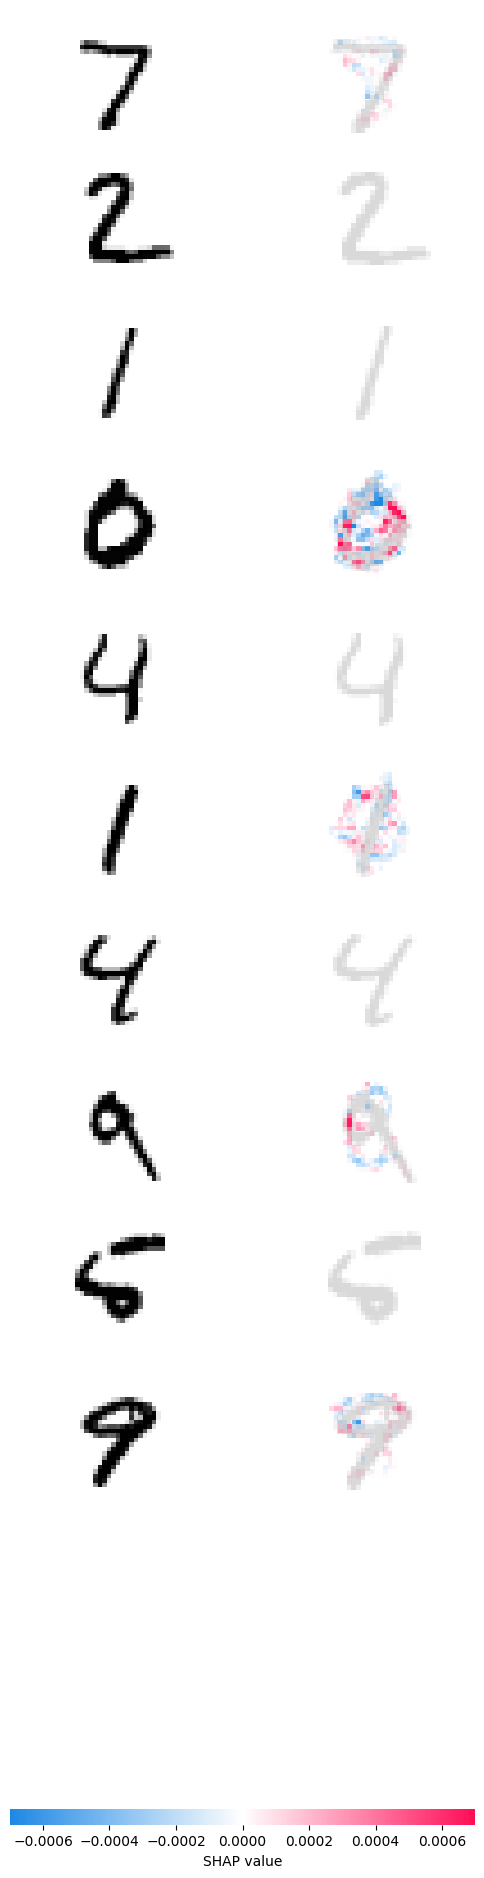

Global Summary Plot saved as global_summary.png


In [24]:
import shap
import numpy as np
import matplotlib.pyplot as plt

background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

explainer = shap.DeepExplainer(model, background)

shap_values = explainer.shap_values(x_test[:10])

shap.image_plot(shap_values, -x_test[:10])

plt.savefig("global_summary.png", dpi=300, bbox_inches='tight')
plt.close()

print("Global Summary Plot saved as global_summary.png")

In [25]:
use_shap = True
try:
    import shap
    print("SHAP version:", shap.__version__)
except Exception as e:
    print("SHAP not available or failed to import:", e)
    use_shap = False

if use_shap:
    try:
        bg_idx = np.random.choice(np.arange(len(x_train)), size=100, replace=False)
        background = x_train[bg_idx]

        try:
            explainer = shap.DeepExplainer(model, background)
            print("Using DeepExplainer")
        except Exception as e:

            print("DeepExplainer failed, trying GradientExplainer:", e)
            explainer = shap.GradientExplainer(model, background)

        shap_values_caseA = explainer.shap_values(x_test[caseA_idx:caseA_idx+1])
        shap_values_caseB = explainer.shap_values(x_test[caseB_idx:caseB_idx+1])

        print("Computed SHAP values for selected instances.")
    except Exception as e:
        print("SHAP explanation failed:", e)
        use_shap = False

SHAP version: 0.49.1
Using DeepExplainer


c:\Users\dalro\eclipse-workspace\Student\src\students\tf_env\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 28, 28, 1))']
  warnings.warn(msg)


Computed SHAP values for selected instances.


## Visualize SHAP Explanations (if SHAP worked)
For image models, SHAP's `image_plot` can overlay explanations on the image.
We will plot the explanation for the *predicted class* of each case.

Case A predicted class: 0 SHAP array shape: (1, 28, 28, 1, 10)


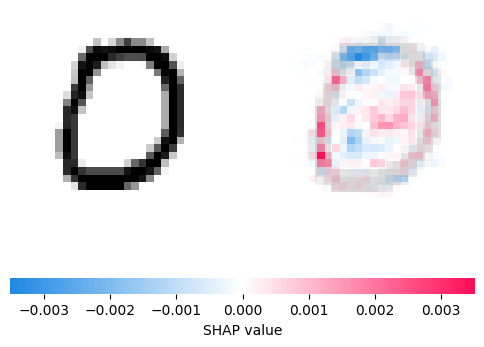

Case B predicted class: 4 SHAP array shape: (1, 28, 28, 1, 10)


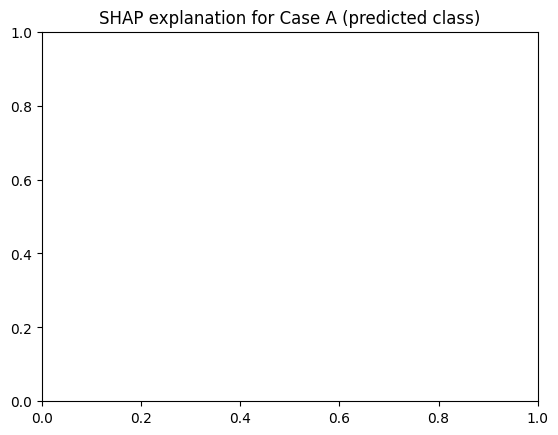

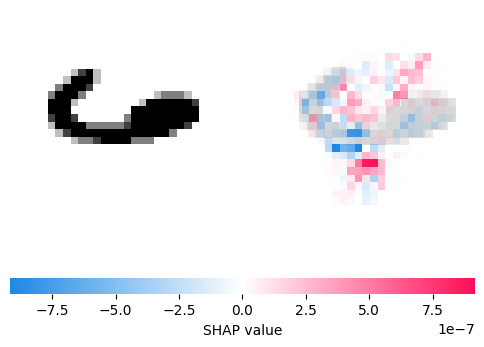

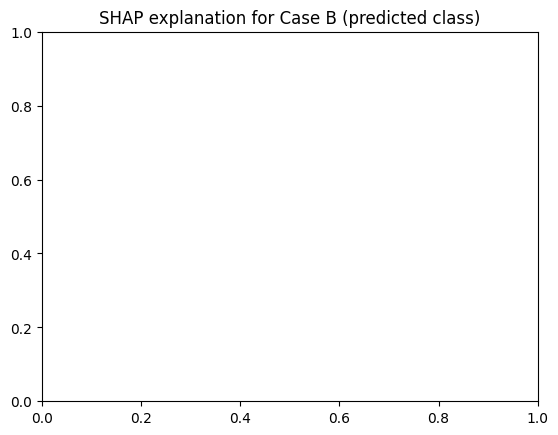

In [19]:
if use_shap:
    try:
        def pick_shap_for_pred(shap_values, pred_label):
            if isinstance(shap_values, list):
                return shap_values[pred_label]
            else:
                arr = np.array(shap_values)
                if arr.ndim >= 4:
                    if arr.shape[1] == 10:
                        return arr[0, pred_label]
                    if arr.shape[0] == 10:
                        return arr[pred_label, 0]
                return shap_values

        predA = int(pred_labels[caseA_idx])
        svA = pick_shap_for_pred(shap_values_caseA, predA)
        print("Case A predicted class:", predA, "SHAP array shape:", np.array(svA).shape)
        shap.image_plot([svA], -x_test[caseA_idx:caseA_idx+1])
        plt.title("SHAP explanation for Case A (predicted class)")

        predB = int(pred_labels[caseB_idx])
        svB = pick_shap_for_pred(shap_values_caseB, predB)
        print("Case B predicted class:", predB, "SHAP array shape:", np.array(svB).shape)
        shap.image_plot([svB], -x_test[caseB_idx:caseB_idx+1])
        plt.title("SHAP explanation for Case B (predicted class)")
    except Exception as e:
        print("Error plotting SHAP images:", e)
        use_shap = False


## LIME Fallback (if SHAP is not available)
If SHAP did not run successfully in your environment, use **LIME** for local explanations. LIME explains predictions by perturbing the input and fitting a local linear model.

In [20]:
if not use_shap:
    try:
        from lime import lime_image
        from skimage.color import gray2rgb
        from skimage.segmentation import mark_boundaries

        def predict_fn(images):
            arr = np.array(images)
            if arr.ndim == 3:
                arr = np.expand_dims(arr, -1)
            arr = arr.astype('float32') / 1.0
            return model.predict(arr)

        explainer = lime_image.LimeImageExplainer()

        def to_rgb(img):
            if img.ndim == 2 or img.shape[-1] == 1:
                return gray2rgb(img.squeeze())
            return img

        imgA_rgb = to_rgb((x_test[caseA_idx].squeeze()))
        explanationA = explainer.explain_instance(imgA_rgb, 
                                                 classifier_fn=predict_fn,
                                                 top_labels=5,
                                                 hide_color=0,
                                                 num_samples=1000)
        predA = int(pred_labels[caseA_idx])
        temp, mask = explanationA.get_image_and_mask(predA, positive_only=False, num_features=5, hide_rest=False)
        plt.figure(figsize=(4,4))
        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"LIME explanation Case A (pred {predA})")
        plt.axis('off')
        plt.show()

        imgB_rgb = to_rgb((x_test[caseB_idx].squeeze()))
        explanationB = explainer.explain_instance(imgB_rgb, 
                                                 classifier_fn=predict_fn,
                                                 top_labels=5,
                                                 hide_color=0,
                                                 num_samples=1000)
        predB = int(pred_labels[caseB_idx])
        temp, mask = explanationB.get_image_and_mask(predB, positive_only=False, num_features=5, hide_rest=False)
        plt.figure(figsize=(4,4))
        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"LIME explanation Case B (pred {predB})")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print("LIME is not available or failed:", e)
        print("To enable LIME, run: pip install lime scikit-image")
